In [1]:
!date

Thu May  4 09:29:22 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [3]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
#import cv2
from skimage.transform import resize
from datetime import datetime
now = datetime.now

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
def load_video(fn):
    import skvideo
    import skvideo.io
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def safe_mkdir(fn):
    import os
    if not os.path.exists(fn):
        os.mkdir(fn)

In [6]:
def resize_and_pad_video(video_data):

    target_size = np.array((360, 640))
    input_size = (video_data.shape[1],video_data.shape[2])
    
    d1 = input_size[0]/target_size[0]
    d2 = input_size[1]/target_size[1]

    choose_size = input_size/max(d1,d2)
    choose_size = choose_size.round().astype(int) ## Hacks?

    video_data_resized = np.array([np.array(Image.fromarray(video_data[frame,:,:,:]).resize(choose_size.astype(int)[-1::-1])) for frame in range(video_data.shape[0])])

    assert any(video_data_resized.shape[1:3]==target_size),'neither dimension matches'

    if not video_data_resized.shape[1]==target_size[0]:

        if np.mod(video_data_resized.shape[1],2)==0:
            p = (target_size[0]-video_data_resized.shape[1])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[0]-video_data_resized.shape[1])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(pp[0],pp[1]),(0,0),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(pp[0],pp[1]),(0,0),(0,0)))[0,:,:,0]

    elif not video_data_resized.shape[2]==target_size[1]:

        if np.mod(video_data_resized.shape[2],2)==0:
            p = (target_size[1]-video_data_resized.shape[2])/2
            pp = (p.astype(int),p.astype(int))
        else:
            p = (target_size[1]-video_data_resized.shape[2])/2
            p = np.floor(p)
            pp = (p.astype(int),p.astype(int)+1)

        video_data_resized_padded = np.pad(video_data_resized,((0,0),(0,0),(pp[0],pp[1]),(0,0)))
        padding = np.pad(np.ones(video_data_resized.shape),((0,0),(0,0),(pp[0],pp[1]),(0,0)))[0,:,:,0]

    else:
        video_data_resized_padded = video_data_resized
        padding = np.ones(video_data_resized.shape)[0,:,:,0]

    assert all(video_data_resized_padded.shape[1:3]==target_size), 'failed resizing'
    
    return video_data_resized_padded,padding

In [7]:
categories = os.listdir('./Data/haa500_v1_1_frames/video/')
categories.sort()
print(categories[0:3])
print(categories[-3::])

['ALS_IceBucket_Challenge', 'CPR', 'abseiling']
['yoga_tree', 'yoga_triangle', 'yoga_updog']


In [8]:
calc_or_load = 'load'

if calc_or_load=='load':
    idx_1p = np.load('good_videos_1p_new_4783.npy')
    
elif calc_or_load=='calc':
    
    idx_1p = np.zeros((20,500))
    box_fn = './Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}_box.npy'
    for c in tqdm(range(500)):
        for v in range(20):
            boxes = [f for f in os.listdir(f'./Data/haa500_v1_1_frames/video/{categories[c]}/{categories[c]}_{v:03d}/') if f.endswith('_box.npy')]
            n = len(boxes)
            idx_1p[v,c] = all([sum(np.load(box_fn.format(c=categories[c],v=v,f=f))[:,-1]==0)==1 for f in range(n)])
    #np.save('good_videos_1p_new_4783.npy',idx_1p)
else:
    print('undefined')

[0. 1.]
4783.0
(20, 500)


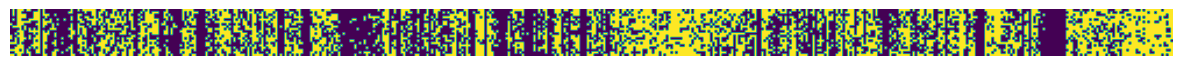

In [9]:
print(np.unique(idx_1p))
print(idx_1p.sum())
print(idx_1p.shape)
plt.figure(figsize=(15,5))
plt.imshow(idx_1p);
plt.axis('off');

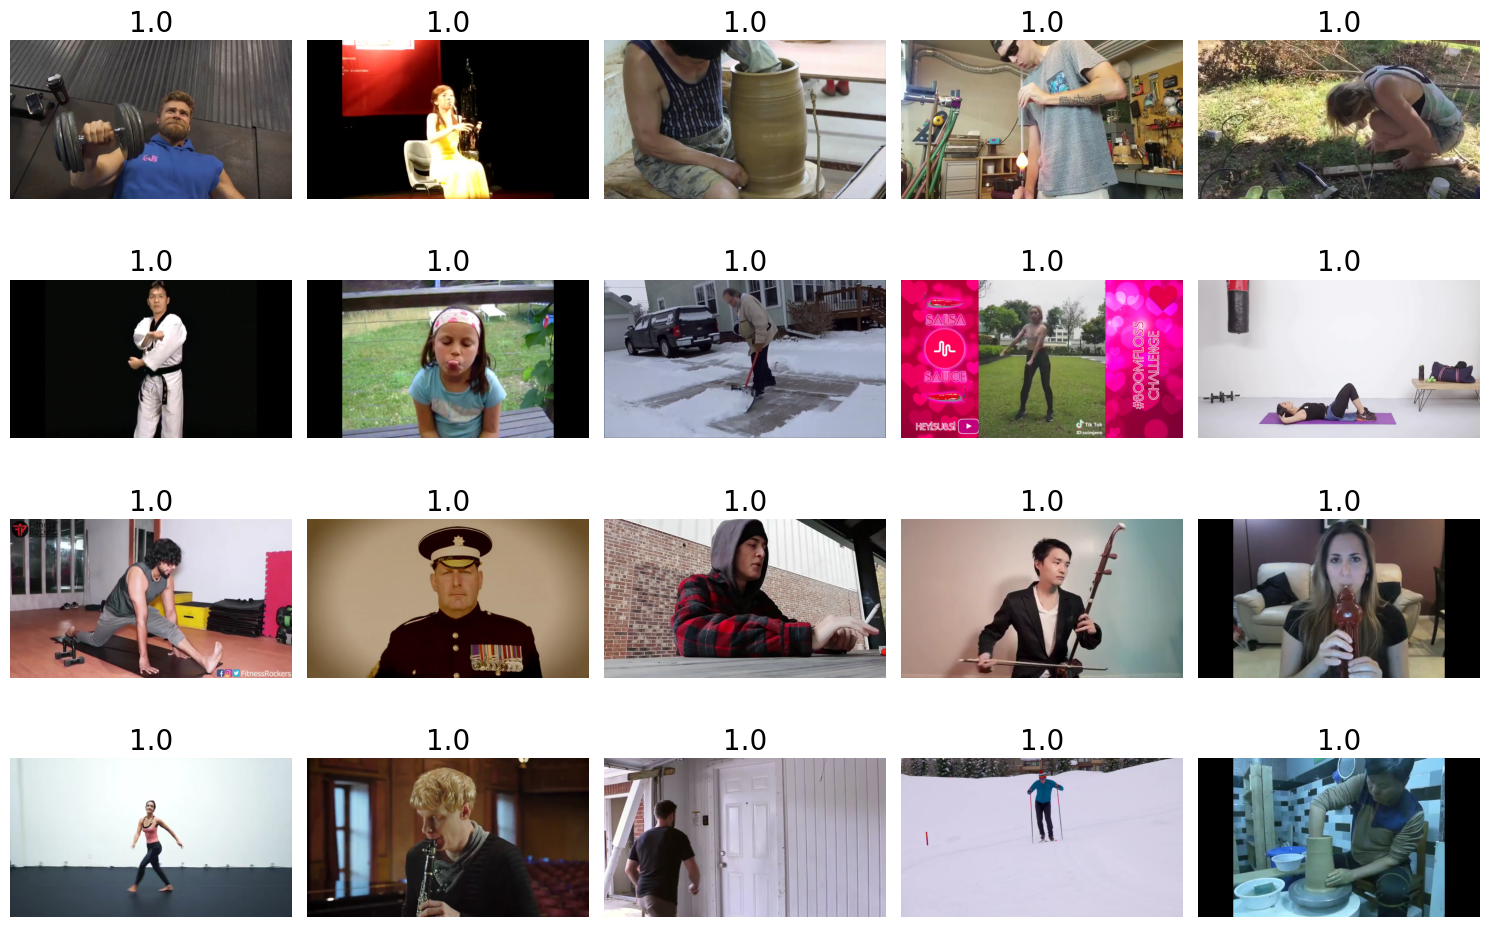

In [10]:
nz = np.nonzero(idx_1p)
plt.figure(figsize=(15,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    r = np.random.randint(low=0,high=len(nz[0]))
    #c = np.random.randint(low=0,high=500)
    #v = np.random.randint(low=0,high=20)
    c = nz[1][r]
    v = nz[0][r]
    f = 0

    im = Image.open('./Data/haa500_v1_1_frames/video/{c}/{c}_{v:03d}/{c}_{v:03d}_{f:03d}.png'.format(c=categories[c],v=v,f=f))
    plt.imshow(np.array(im))
    plt.axis('off')
    plt.title(idx_1p[v,c],fontsize=20)
    
plt.tight_layout()

In [11]:
has_vids = np.zeros((20,500))
for c in tqdm(range(500)):
    for v in range(20):
        fn1 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'.format(c=categories[c],v=v)
        fn2 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'.format(c=categories[c],v=v)
        fn3 = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'.format(c=categories[c],v=v)
        has_vids[v,c] = all([os.path.exists(fn) for fn in [fn1,fn2,fn3]])

  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 4/500 [00:00<00:15, 32.05it/s]

  2%|▏         | 8/500 [00:00<00:14, 32.98it/s]

  2%|▏         | 12/500 [00:00<00:14, 33.62it/s]

  3%|▎         | 16/500 [00:00<00:14, 32.98it/s]

  4%|▍         | 20/500 [00:00<00:14, 33.93it/s]

  5%|▌         | 25/500 [00:00<00:12, 37.04it/s]

  6%|▌         | 30/500 [00:00<00:12, 38.61it/s]

  7%|▋         | 34/500 [00:00<00:12, 37.45it/s]

  8%|▊         | 38/500 [00:01<00:12, 36.40it/s]

  8%|▊         | 42/500 [00:01<00:12, 35.92it/s]

  9%|▉         | 46/500 [00:01<00:12, 35.45it/s]

 10%|█         | 50/500 [00:01<00:12, 34.99it/s]

 11%|█         | 54/500 [00:01<00:13, 33.97it/s]

 12%|█▏        | 58/500 [00:01<00:13, 33.79it/s]

 12%|█▏        | 62/500 [00:01<00:12, 33.94it/s]

 13%|█▎        | 66/500 [00:01<00:12, 34.46it/s]

 14%|█▍        | 70/500 [00:02<00:12, 34.71it/s]

 15%|█▌        | 75/500 [00:02<00:11, 36.58it/s]

 16%|█▌        | 80/500 [00:02<00:10, 38.21it/s]

 17%|█▋        | 85/500 [00:02<00:10, 39.64it/s]

 18%|█▊        | 90/500 [00:02<00:10, 40.58it/s]

 19%|█▉        | 95/500 [00:02<00:10, 40.16it/s]

 20%|██        | 100/500 [00:02<00:09, 40.45it/s]

 21%|██        | 105/500 [00:02<00:09, 41.38it/s]

 22%|██▏       | 110/500 [00:02<00:08, 43.47it/s]

 23%|██▎       | 115/500 [00:03<00:09, 41.83it/s]

 24%|██▍       | 120/500 [00:03<00:09, 40.90it/s]

 25%|██▌       | 125/500 [00:03<00:09, 39.27it/s]

 26%|██▌       | 131/500 [00:03<00:08, 42.99it/s]

 27%|██▋       | 136/500 [00:03<00:08, 40.72it/s]

 28%|██▊       | 141/500 [00:03<00:09, 39.52it/s]

 29%|██▉       | 146/500 [00:03<00:08, 39.93it/s]

 30%|███       | 151/500 [00:03<00:08, 40.26it/s]

 31%|███       | 156/500 [00:04<00:08, 40.75it/s]

 32%|███▏      | 161/500 [00:04<00:08, 41.50it/s]

 33%|███▎      | 166/500 [00:04<00:08, 38.61it/s]

 34%|███▍      | 171/500 [00:04<00:08, 39.17it/s]

 35%|███▌      | 175/500 [00:04<00:08, 38.31it/s]

 36%|███▌      | 179/500 [00:04<00:08, 37.60it/s]

 37%|███▋      | 183/500 [00:04<00:08, 37.12it/s]

 37%|███▋      | 187/500 [00:04<00:08, 36.47it/s]

 38%|███▊      | 191/500 [00:05<00:08, 36.16it/s]

 39%|███▉      | 195/500 [00:05<00:08, 35.19it/s]

 40%|███▉      | 199/500 [00:05<00:08, 35.58it/s]

 41%|████      | 203/500 [00:05<00:08, 35.91it/s]

 41%|████▏     | 207/500 [00:05<00:08, 35.89it/s]

 42%|████▏     | 211/500 [00:05<00:07, 36.18it/s]

 43%|████▎     | 215/500 [00:05<00:07, 36.22it/s]

 44%|████▍     | 219/500 [00:05<00:07, 35.54it/s]

 45%|████▍     | 223/500 [00:05<00:07, 36.19it/s]

 45%|████▌     | 227/500 [00:06<00:08, 33.70it/s]

 46%|████▌     | 231/500 [00:06<00:07, 34.61it/s]

 47%|████▋     | 235/500 [00:06<00:07, 35.25it/s]

 48%|████▊     | 239/500 [00:06<00:08, 31.57it/s]

 49%|████▊     | 243/500 [00:06<00:07, 32.59it/s]

 49%|████▉     | 247/500 [00:06<00:07, 33.96it/s]

 50%|█████     | 252/500 [00:06<00:06, 37.31it/s]

 51%|█████▏    | 257/500 [00:06<00:06, 38.43it/s]

 52%|█████▏    | 262/500 [00:07<00:06, 38.77it/s]

 53%|█████▎    | 266/500 [00:07<00:06, 38.36it/s]

 54%|█████▍    | 270/500 [00:07<00:05, 38.46it/s]

 55%|█████▌    | 275/500 [00:07<00:05, 39.33it/s]

 56%|█████▌    | 279/500 [00:07<00:05, 37.48it/s]

 57%|█████▋    | 283/500 [00:07<00:06, 34.82it/s]

 57%|█████▋    | 287/500 [00:07<00:06, 34.21it/s]

 58%|█████▊    | 291/500 [00:07<00:06, 33.85it/s]

 59%|█████▉    | 295/500 [00:07<00:06, 33.85it/s]

 60%|█████▉    | 299/500 [00:08<00:05, 34.33it/s]

 61%|██████    | 303/500 [00:08<00:06, 32.70it/s]

 61%|██████▏   | 307/500 [00:08<00:06, 31.85it/s]

 62%|██████▏   | 311/500 [00:08<00:05, 32.55it/s]

 63%|██████▎   | 315/500 [00:08<00:05, 32.49it/s]

 64%|██████▍   | 319/500 [00:08<00:05, 32.32it/s]

 65%|██████▍   | 323/500 [00:08<00:05, 33.62it/s]

 65%|██████▌   | 327/500 [00:08<00:05, 33.03it/s]

 66%|██████▌   | 331/500 [00:09<00:05, 31.74it/s]

 67%|██████▋   | 335/500 [00:09<00:05, 30.53it/s]

 68%|██████▊   | 339/500 [00:09<00:05, 30.22it/s]

 69%|██████▊   | 343/500 [00:09<00:05, 29.89it/s]

 69%|██████▉   | 347/500 [00:09<00:04, 31.03it/s]

 70%|███████   | 351/500 [00:09<00:04, 31.52it/s]

 71%|███████   | 355/500 [00:09<00:04, 31.93it/s]

 72%|███████▏  | 359/500 [00:09<00:04, 31.61it/s]

 73%|███████▎  | 363/500 [00:10<00:04, 30.33it/s]

 73%|███████▎  | 367/500 [00:10<00:04, 29.07it/s]

 74%|███████▍  | 370/500 [00:10<00:04, 28.82it/s]

 75%|███████▍  | 373/500 [00:10<00:04, 28.93it/s]

 76%|███████▌  | 378/500 [00:10<00:03, 32.70it/s]

 76%|███████▋  | 382/500 [00:10<00:03, 33.66it/s]

 77%|███████▋  | 386/500 [00:10<00:03, 33.62it/s]

 78%|███████▊  | 391/500 [00:10<00:03, 34.93it/s]

 79%|███████▉  | 395/500 [00:11<00:03, 32.56it/s]

 80%|███████▉  | 399/500 [00:11<00:03, 31.20it/s]

 81%|████████  | 403/500 [00:11<00:03, 30.57it/s]

 81%|████████▏ | 407/500 [00:11<00:03, 29.92it/s]

 82%|████████▏ | 411/500 [00:11<00:03, 29.14it/s]

 83%|████████▎ | 414/500 [00:11<00:02, 28.73it/s]

 84%|████████▍ | 421/500 [00:11<00:02, 36.35it/s]

 85%|████████▌ | 425/500 [00:12<00:02, 33.87it/s]

 86%|████████▌ | 429/500 [00:12<00:02, 32.03it/s]

 87%|████████▋ | 433/500 [00:12<00:02, 31.80it/s]

 87%|████████▋ | 437/500 [00:12<00:02, 30.26it/s]

 88%|████████▊ | 441/500 [00:12<00:02, 29.21it/s]

 89%|████████▉ | 445/500 [00:12<00:01, 30.96it/s]

 90%|████████▉ | 449/500 [00:12<00:01, 29.54it/s]

 91%|█████████ | 453/500 [00:13<00:01, 31.04it/s]

 91%|█████████▏| 457/500 [00:13<00:01, 28.55it/s]

 92%|█████████▏| 460/500 [00:13<00:01, 28.15it/s]

 93%|█████████▎| 463/500 [00:13<00:01, 28.58it/s]

 93%|█████████▎| 466/500 [00:13<00:01, 28.72it/s]

 94%|█████████▍| 470/500 [00:13<00:01, 29.34it/s]

 95%|█████████▍| 473/500 [00:13<00:00, 29.22it/s]

 95%|█████████▌| 476/500 [00:13<00:00, 28.68it/s]

 96%|█████████▌| 479/500 [00:13<00:00, 25.37it/s]

 96%|█████████▋| 482/500 [00:14<00:00, 25.45it/s]

 97%|█████████▋| 485/500 [00:14<00:00, 26.02it/s]

 98%|█████████▊| 488/500 [00:14<00:00, 26.07it/s]

 98%|█████████▊| 491/500 [00:14<00:00, 26.73it/s]

 99%|█████████▉| 494/500 [00:14<00:00, 27.54it/s]

100%|█████████▉| 498/500 [00:14<00:00, 29.30it/s]

100%|██████████| 500/500 [00:14<00:00, 33.95it/s]

In [12]:
print(has_vids.sum())
print((has_vids==0).sum())

9371.0
629


In [13]:
good_videos_xl = has_vids.astype(bool)*idx_1p.astype(bool)
good_videos_xl.shape

(20, 500)

In [14]:
print(sum(good_videos_xl.sum(axis=0)>=17))
print(sum(good_videos_xl.sum(axis=0)>=15))
print(sum(good_videos_xl.sum(axis=0)>=10))

60
121
280


In [15]:
minVids = 10

In [16]:
good_videos_xl[:,good_videos_xl.sum(axis=0)<minVids]=0

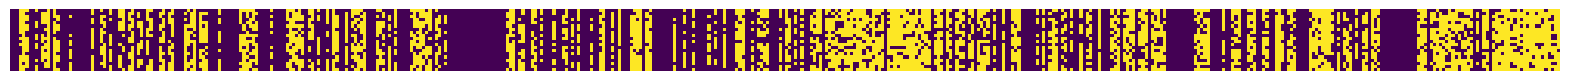

In [17]:
plt.figure(figsize=(20,5))
plt.imshow(good_videos_xl)
plt.axis('off');

In [18]:
good_cats = np.nonzero(good_videos_xl.sum(axis=0)>=minVids)[0]
good_cats_list = list(np.array(categories)[good_cats])
good_vids = [np.nonzero(good_videos_xl[:,good_cat])[0][0:minVids] for good_cat in good_cats]

In [19]:
ng = len(good_cats)
print(ng)

280


In [20]:
# parameters
outdir = './Data/pytorch-data/xl_121_15_action_data_orig'
fn_temp = './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4'
# './Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_inp_seg.mp4'
#fn_temp = './Data/haa500_v1_1_resized/video/{c}/{c}_{v:03d}.mp4'

In [21]:
# Parameters
outdir = "./Data/pytorch-data/xl_280_10_action_data_seg"
fn_temp = "./Data/haa500_v1_1_yolo_seg4/{c}/{c}_{v:03d}_item_0_fwd_seg.mp4"


In [22]:
## Make/Define Directories
safe_mkdir(outdir)

safe_mkdir(os.path.join(outdir,'train'))
safe_mkdir(os.path.join(outdir,'val'))
safe_mkdir(os.path.join(outdir,'test'))

[safe_mkdir(os.path.join(outdir,'train',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'val',category)) for category in good_cats_list];
[safe_mkdir(os.path.join(outdir,'test',category)) for category in good_cats_list];

In [23]:
# Run Main Loop
for c in tqdm(range(ng)):
    for v in range(minVids):              
        fn = fn_temp.format(c=categories[good_cats[c]],v=good_vids[c][v])
        video_data = load_video(fn)
        assert all((video_data.shape[1]==360,video_data.shape[2]==640)),f'bad size dumbass: {video_data.shape}'
        
        nframes = video_data.shape[0]
        video_data = resize(np.pad(video_data,((0,0),(140,140),(0,0),(0,0))),(nframes,224,224,3)) # resize to 244*244 (0-1 range)
        video_data = (video_data*255).astype(np.uint8) # make into 0-255 uint
              
        if v==0:
            outdir_subfolder = os.path.join(outdir,'val',categories[good_cats[c]])
        elif v==1:
            outdir_subfolder = os.path.join(outdir,'test',categories[good_cats[c]])
        else:
            outdir_subfolder = os.path.join(outdir,'train',categories[good_cats[c]])

        [Image.fromarray(video_data[f,:,:,:]).save(os.path.join(outdir_subfolder,f'{good_vids[c][v]:03d}_{f:03d}.jpg')) for f in range(nframes)];

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 1/280 [01:29<6:55:47, 89.42s/it]

  1%|          | 2/280 [01:54<3:58:20, 51.44s/it]

  1%|          | 3/280 [04:57<8:35:51, 111.74s/it]

  1%|▏         | 4/280 [32:36<55:23:08, 722.42s/it]

  2%|▏         | 5/280 [33:20<36:30:40, 477.97s/it]

  2%|▏         | 6/280 [59:30<64:37:23, 849.07s/it]

  2%|▎         | 7/280 [1:11:42<61:29:15, 810.82s/it]

  3%|▎         | 8/280 [1:15:12<46:48:10, 619.45s/it]

  3%|▎         | 9/280 [1:15:24<32:20:40, 429.67s/it]

  4%|▎         | 10/280 [1:15:42<22:40:59, 302.44s/it]

  4%|▍         | 11/280 [1:18:40<19:45:24, 264.40s/it]

  4%|▍         | 12/280 [1:19:03<14:13:01, 190.98s/it]

  5%|▍         | 13/280 [1:19:20<10:15:06, 138.23s/it]

  5%|▌         | 14/280 [1:19:43<7:38:50, 103.50s/it] 

  5%|▌         | 15/280 [1:21:29<7:40:07, 104.18s/it]

  6%|▌         | 16/280 [1:22:25<6:35:33, 89.90s/it] 

  6%|▌         | 17/280 [1:41:20<29:31:30, 404.15s/it]

  6%|▋         | 18/280 [1:41:51<21:14:40, 291.91s/it]

  7%|▋         | 19/280 [1:42:07<15:09:15, 209.02s/it]

  7%|▋         | 20/280 [1:51:00<22:07:04, 306.25s/it]

  8%|▊         | 21/280 [1:52:46<17:42:51, 246.22s/it]

  8%|▊         | 22/280 [2:22:59<51:20:28, 716.39s/it]

  8%|▊         | 23/280 [2:23:31<36:28:54, 511.03s/it]

  9%|▊         | 24/280 [2:23:59<26:01:44, 366.03s/it]

  9%|▉         | 25/280 [2:24:30<18:48:24, 265.51s/it]

  9%|▉         | 26/280 [3:12:10<73:39:08, 1043.89s/it]

 10%|▉         | 27/280 [3:12:31<51:48:36, 737.22s/it] 

 10%|█         | 28/280 [3:34:19<63:35:38, 908.49s/it]

 10%|█         | 29/280 [3:54:47<70:00:38, 1004.14s/it]

 11%|█         | 30/280 [4:53:30<122:13:07, 1759.95s/it]

 11%|█         | 31/280 [5:29:39<130:13:31, 1882.78s/it]

 11%|█▏        | 32/280 [5:29:58<91:09:53, 1323.36s/it] 

 12%|█▏        | 33/280 [6:00:54<101:46:30, 1483.36s/it]

 12%|█▏        | 34/280 [6:34:04<111:45:08, 1635.40s/it]

 12%|█▎        | 35/280 [7:02:47<113:04:58, 1661.63s/it]

 13%|█▎        | 36/280 [7:30:13<112:18:13, 1656.94s/it]

 13%|█▎        | 37/280 [7:43:47<94:46:36, 1404.10s/it] 

 14%|█▎        | 38/280 [7:44:12<66:34:03, 990.26s/it] 

 14%|█▍        | 39/280 [7:44:51<47:11:19, 704.89s/it]

 14%|█▍        | 40/280 [7:45:15<33:22:50, 500.71s/it]

 15%|█▍        | 41/280 [7:45:39<23:44:14, 357.55s/it]

 15%|█▌        | 42/280 [7:46:16<17:17:12, 261.48s/it]

 15%|█▌        | 43/280 [7:46:47<12:39:26, 192.26s/it]

 16%|█▌        | 44/280 [7:47:18<9:26:14, 143.96s/it] 

 16%|█▌        | 45/280 [7:47:45<7:05:40, 108.68s/it]

 16%|█▋        | 46/280 [7:48:05<5:20:14, 82.11s/it] 

 17%|█▋        | 47/280 [7:48:18<3:58:12, 61.34s/it]

 17%|█▋        | 48/280 [7:48:45<3:18:25, 51.32s/it]

 18%|█▊        | 49/280 [7:49:20<2:57:44, 46.17s/it]

 18%|█▊        | 50/280 [7:49:47<2:35:39, 40.61s/it]

 18%|█▊        | 51/280 [7:50:13<2:17:40, 36.07s/it]

 19%|█▊        | 52/280 [7:50:40<2:06:41, 33.34s/it]

 19%|█▉        | 53/280 [7:51:08<2:00:22, 31.82s/it]

 19%|█▉        | 54/280 [7:51:27<1:45:45, 28.08s/it]

 20%|█▉        | 55/280 [7:52:02<1:53:05, 30.16s/it]

 20%|██        | 56/280 [7:52:50<2:11:48, 35.30s/it]

 20%|██        | 57/280 [7:53:11<1:55:54, 31.19s/it]

 21%|██        | 58/280 [7:53:44<1:56:59, 31.62s/it]

 21%|██        | 59/280 [7:54:08<1:48:45, 29.53s/it]

 21%|██▏       | 60/280 [7:54:46<1:56:57, 31.90s/it]

 22%|██▏       | 61/280 [7:54:56<1:32:42, 25.40s/it]

 22%|██▏       | 62/280 [7:55:12<1:21:51, 22.53s/it]

 22%|██▎       | 63/280 [7:55:30<1:17:08, 21.33s/it]

 23%|██▎       | 64/280 [7:55:57<1:22:11, 22.83s/it]

 23%|██▎       | 65/280 [7:56:43<1:47:01, 29.87s/it]

 24%|██▎       | 66/280 [7:56:58<1:30:11, 25.29s/it]

 24%|██▍       | 67/280 [7:57:29<1:35:42, 26.96s/it]

 24%|██▍       | 68/280 [7:57:53<1:33:01, 26.33s/it]

 25%|██▍       | 69/280 [7:58:40<1:54:11, 32.47s/it]

 25%|██▌       | 70/280 [7:59:10<1:50:17, 31.51s/it]

 25%|██▌       | 71/280 [7:59:40<1:48:23, 31.12s/it]

 26%|██▌       | 72/280 [8:00:13<1:49:52, 31.69s/it]

 26%|██▌       | 73/280 [8:00:38<1:42:19, 29.66s/it]

 26%|██▋       | 74/280 [8:01:14<1:48:35, 31.63s/it]

 27%|██▋       | 75/280 [8:01:43<1:45:31, 30.88s/it]

 27%|██▋       | 76/280 [8:02:12<1:42:41, 30.21s/it]

 28%|██▊       | 77/280 [8:02:32<1:32:23, 27.31s/it]

 28%|██▊       | 78/280 [8:18:19<17:00:38, 303.16s/it]

 28%|██▊       | 79/280 [8:32:26<26:02:23, 466.39s/it]

 29%|██▊       | 80/280 [9:05:06<50:48:23, 914.52s/it]

 29%|██▉       | 81/280 [9:11:29<41:43:51, 754.93s/it]

 29%|██▉       | 82/280 [9:39:24<56:42:16, 1030.99s/it]

 30%|██▉       | 83/280 [10:07:52<67:31:52, 1234.07s/it]

 30%|███       | 84/280 [10:08:00<47:10:11, 866.38s/it] 

 30%|███       | 85/280 [10:08:19<33:09:27, 612.14s/it]

 31%|███       | 86/280 [10:53:03<66:28:36, 1233.59s/it]

 31%|███       | 87/280 [10:54:57<48:07:13, 897.58s/it] 

 31%|███▏      | 88/280 [10:57:48<36:15:20, 679.79s/it]

 32%|███▏      | 89/280 [10:58:19<25:43:59, 485.03s/it]

 32%|███▏      | 90/280 [11:17:37<36:15:36, 687.04s/it]

 32%|███▎      | 91/280 [11:18:02<25:38:32, 488.42s/it]

 33%|███▎      | 92/280 [11:18:28<18:15:08, 349.51s/it]

 33%|███▎      | 93/280 [11:18:48<13:01:13, 250.66s/it]

 34%|███▎      | 94/280 [11:19:11<9:25:16, 182.35s/it] 

 34%|███▍      | 95/280 [11:19:31<6:52:19, 133.73s/it]

 34%|███▍      | 96/280 [11:19:58<5:11:51, 101.69s/it]

 35%|███▍      | 97/280 [11:20:27<4:04:09, 80.05s/it] 

 35%|███▌      | 98/280 [11:20:49<3:09:43, 62.55s/it]

 35%|███▌      | 99/280 [11:21:06<2:27:34, 48.92s/it]

 36%|███▌      | 100/280 [11:21:49<2:21:24, 47.14s/it]

 36%|███▌      | 101/280 [11:22:03<1:51:12, 37.28s/it]

 36%|███▋      | 102/280 [11:22:33<1:43:52, 35.01s/it]

 37%|███▋      | 103/280 [11:22:47<1:24:42, 28.71s/it]

 37%|███▋      | 104/280 [11:23:17<1:25:39, 29.20s/it]

 38%|███▊      | 105/280 [11:23:38<1:17:59, 26.74s/it]

 38%|███▊      | 106/280 [11:24:04<1:16:16, 26.30s/it]

 38%|███▊      | 107/280 [11:24:16<1:04:03, 22.22s/it]

 39%|███▊      | 108/280 [11:24:26<52:53, 18.45s/it]  

 39%|███▉      | 109/280 [11:24:57<1:03:32, 22.30s/it]

 39%|███▉      | 110/280 [11:25:35<1:15:52, 26.78s/it]

 40%|███▉      | 111/280 [11:26:04<1:17:14, 27.42s/it]

 40%|████      | 112/280 [11:26:46<1:29:03, 31.81s/it]

 40%|████      | 113/280 [11:27:26<1:36:01, 34.50s/it]

 41%|████      | 114/280 [11:28:05<1:38:42, 35.68s/it]

 41%|████      | 115/280 [11:28:53<1:48:17, 39.38s/it]

 41%|████▏     | 116/280 [11:29:11<1:30:30, 33.11s/it]

 42%|████▏     | 117/280 [11:29:36<1:23:25, 30.71s/it]

 42%|████▏     | 118/280 [11:30:11<1:26:16, 31.95s/it]

 42%|████▎     | 119/280 [11:30:28<1:13:29, 27.39s/it]

 43%|████▎     | 120/280 [11:30:55<1:12:55, 27.34s/it]

 43%|████▎     | 121/280 [11:31:22<1:12:18, 27.29s/it]

 44%|████▎     | 122/280 [11:31:52<1:13:26, 27.89s/it]

 44%|████▍     | 123/280 [11:32:15<1:09:01, 26.38s/it]

 44%|████▍     | 124/280 [11:32:38<1:06:13, 25.47s/it]

 45%|████▍     | 125/280 [11:32:57<1:00:38, 23.47s/it]

 45%|████▌     | 126/280 [11:33:33<1:10:19, 27.40s/it]

 45%|████▌     | 127/280 [11:34:11<1:18:02, 30.60s/it]

 46%|████▌     | 128/280 [11:34:36<1:13:21, 28.96s/it]

 46%|████▌     | 129/280 [11:34:51<1:02:14, 24.73s/it]

 46%|████▋     | 130/280 [11:35:07<55:00, 22.00s/it]  

 47%|████▋     | 131/280 [11:35:33<57:22, 23.10s/it]

 47%|████▋     | 132/280 [11:36:07<1:05:29, 26.55s/it]

 48%|████▊     | 133/280 [11:36:35<1:05:42, 26.82s/it]

 48%|████▊     | 134/280 [11:37:06<1:08:42, 28.24s/it]

 48%|████▊     | 135/280 [12:55:37<57:43:18, 1433.09s/it]

 49%|████▊     | 136/280 [13:04:04<46:12:19, 1155.13s/it]

 49%|████▉     | 137/280 [13:04:51<32:40:47, 822.71s/it] 

 49%|████▉     | 138/280 [14:24:23<79:11:05, 2007.50s/it]

 50%|████▉     | 139/280 [14:26:03<56:13:06, 1435.36s/it]

 50%|█████     | 140/280 [14:59:48<62:41:47, 1612.19s/it]

 50%|█████     | 141/280 [15:06:54<48:30:34, 1256.36s/it]

 51%|█████     | 142/280 [15:07:27<34:05:31, 889.36s/it] 

 51%|█████     | 143/280 [15:08:13<24:12:54, 636.31s/it]

 51%|█████▏    | 144/280 [15:08:44<17:10:32, 454.65s/it]

 52%|█████▏    | 145/280 [15:09:20<12:20:18, 329.03s/it]

 52%|█████▏    | 146/280 [15:09:46<8:51:56, 238.18s/it] 

 52%|█████▎    | 147/280 [15:10:18<6:31:09, 176.47s/it]

 53%|█████▎    | 148/280 [15:11:01<4:59:34, 136.17s/it]

 53%|█████▎    | 149/280 [15:12:00<4:06:48, 113.04s/it]

 54%|█████▎    | 150/280 [15:12:32<3:12:14, 88.73s/it] 

 54%|█████▍    | 151/280 [15:48:59<25:44:21, 718.30s/it]

 54%|█████▍    | 152/280 [17:13:33<72:00:21, 2025.17s/it]

 55%|█████▍    | 153/280 [17:49:29<72:49:19, 2064.25s/it]

 55%|█████▌    | 154/280 [18:44:11<85:02:08, 2429.59s/it]

 55%|█████▌    | 155/280 [19:16:02<78:57:51, 2274.17s/it]

 56%|█████▌    | 156/280 [19:47:46<74:30:14, 2163.02s/it]

 56%|█████▌    | 157/280 [20:03:34<61:27:01, 1798.55s/it]